In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import networkx as nx
np.set_printoptions(suppress=True)

random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)

# Toy scenario

In [2]:
from causememaybe.toy import DataGeneratingProcess
from causememaybe.toy.generate_toy import alpha_0_func, alpha_1_func, m_0_func, m_1_func, sample_weibull
from causememaybe.toy.visualise import plot_dataset, plot_treatment

n_samples = 5000
noise = 0.4
random_state = 9

In [3]:
dgp = DataGeneratingProcess(
                            n_samples=n_samples,
                            noise=noise,
                            random_state=random_state,
                            censoring_rate=2.5,
                            overlap="random",
                            proportional_hazards=True
                           )

Suppose we have a dataset. Where every patient's continious features are generated according to sklearn's [*make_moons*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset. The classification label generated from this dataset is treated as a latent (unobserved) binary factor in our case denoted as $G \in \{0, 1\}$ - the idea is that it will confound our results. We plot this dataset below. 

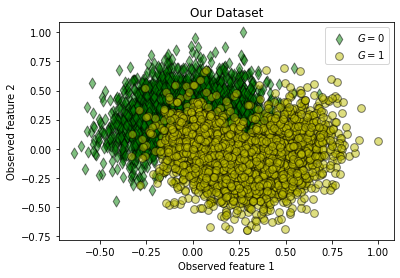

In [4]:
fig, ax = plot_dataset(dgp)

In our case we have a "subject" with continious features $X \in \mathcal{X}$, and unobserved categorical feature $G \in \{0, 1\}$. A subject could be a patient in the medical experiment or observational data, or an app user on facebook's platform.

### Treatment Assignment

#### Random Controlled Trial

Next we need to know what sort of treatment assignment we have in our data. If we are working with a randomized controlled trial (RCT), we know our treatment assignemnt $A$ will be random, and the propensity score will be 0.5 independent of the subjects covariates $X$. 

$
A \sim \text{Bernouli}(0.5)
$

we have the following plot that where marker shape shows latent variable value and color shows treatment assignment in the figure on the left. The figure on the right illiustrates how concentrated the propensity score is for both treated and control.

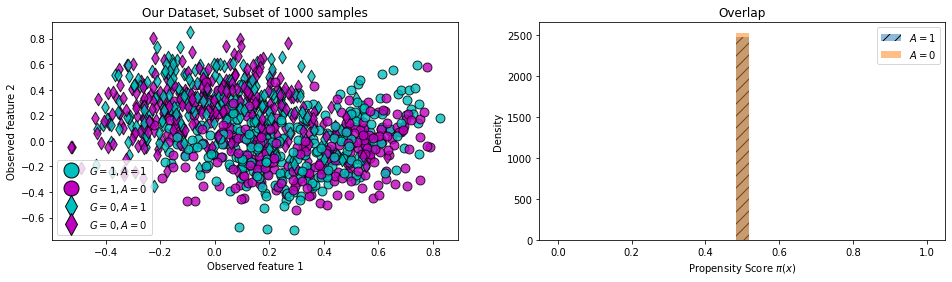

In [5]:
fig, axes = plot_treatment(dgp)

#### Observational Dataset

Now what is propensity score? A propensity score $\pi(x)$ is the probability of a unit (e.g., person, classroom, school) being assigned to a particular treatment given a set of observed covariates, namely:

$
\pi(x)= \mathbb{P}_\theta (A = 1 | X = x)
$

In essence, $\pi$ is the treatment assignment mechanism. In our case, we assume that in our observational dataset doctors had some partial knowledge about the underlying features $X$ and $G$ of the patients, and were able to some extend group them. We model it as a linear relationship between the patient's observed features $X$ and the log-odds (also called logit) of the $G=1$, which is a linear logistic regression $\text{sigmoid}(\beta_0 + \beta_1 x_1 + \beta_2 x_2)$. $\beta_0$ is set to have approximately 0.5 proportion of treated. $(\beta_1, \beta_2) = (1.18 \gamma, -1.76 \gamma)$, where $\gamma \in \{0.5, 1, 4 \}$ for strong, moderate and weak overlap. The higher is the overlap, the better are the doctors in determining the unobserved confounder $G$.

Check the impact your censoring rate might have!


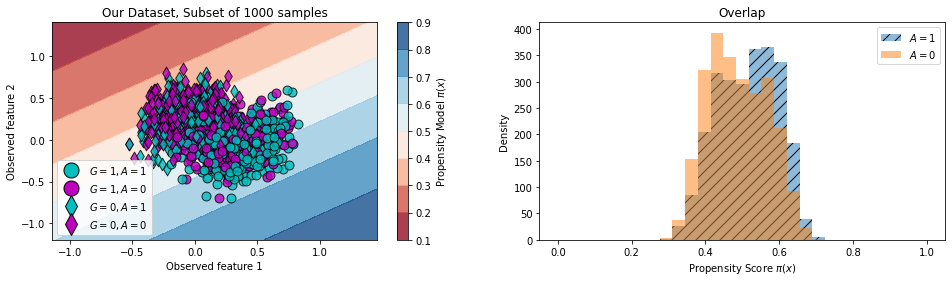

In [6]:
dgp_strong_overlap = DataGeneratingProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            censoring_rate=1,
                            overlap="strong",
                            proportional_hazards=True
                           )
fig, axes = plot_treatment(dgp_strong_overlap)

Check the impact your censoring rate might have!


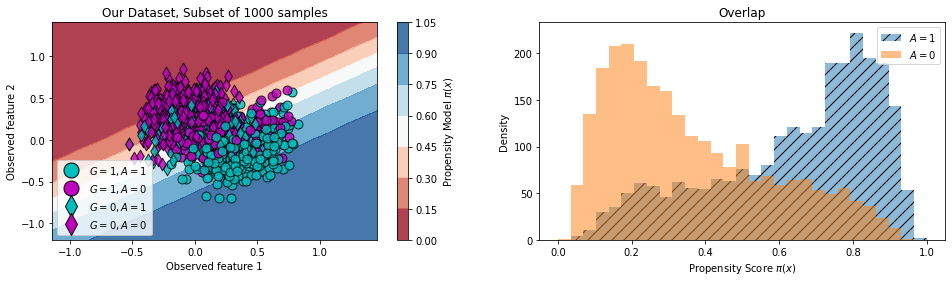

In [7]:
dgp_moderate_overlap = DataGeneratingProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            censoring_rate=1,
                            overlap="moderate",
                            proportional_hazards=True
                           )
fig, axes = plot_treatment(dgp_moderate_overlap)

Check the impact your censoring rate might have!


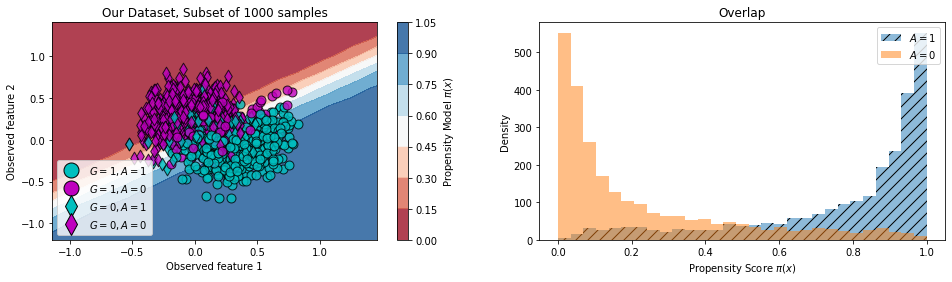

In [8]:
dgp_weak_overlap = DataGeneratingProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            censoring_rate=1,
                            overlap="weak",
                            proportional_hazards=True
                           )
fig, axes = plot_treatment(dgp_weak_overlap)

Later, we will cover the significance of overlap.

$A \in \{0, 1\}$ denotes a treatment variable, in this case we have only two treatment options: $A=0$ for no treatment, or control; and $A=1$ to indicate that a subject has been assigned to a treatment (e.g. new feature in an app, or hemeotherapy for a patient). 

### Survival times

The outcome variable $Y \in \mathbb{R}^{+}$, is the survival time that we have actually observed in the experiment for a particular subject. The observed outcome $Y$ takes on values of either of the two "potential outcomes" $Y_{A=1}$ or $Y_{A=0}$ which depends on the value that $A$ takes, unless cenosring time $C$ has happened earlier than the potential outcome $Y_{A}$, hence $Y = \min \big( [AY_{A=1} + (1-A)Y_{A=0}], C \big) \text{,   } \delta = 1 \text{ if } Y_{A} < C, \text{ else } \delta = 0$. There could also be a case that we have treatment specific censoring processes, then we would have $C_{A=0}$ and $C_{A=1}$, with their underlying generative process - that could be informative and uninformative. For the purpose of this example we will assume uninformative censoring that is independent of treatment.

In this work we generate survival times according to Webull distribution

$
Y_{A} = \Big[ \frac{- \log(U)}{ \lambda_{A} \exp \{m_{A}(X, G)\}} \Big]^{1/\alpha}, U \sim \text{Uniform}(0, 1), \forall A \in \{0, 1\}
$

$\lambda_{A=0} = 1200$ and $\lambda_{A=1} = 2000$ are scale parameters ($\lambda > 0$), and $\alpha > 0$ is the shape paramter to induce non-proportional hazards.To satisfy proportional hazards we can set shape paramter to $\alpha=2$.

$
m_{A=0} = -0.2 + 0.1/(1 + \exp(-X_1)) - 0.8 \sin(X_2) - 0.5(1 - G) \\
m_{A=1} = -0.1 + 0.1 X_1^{2} - 0.2 \sin(X_2) + 0.5 G
$

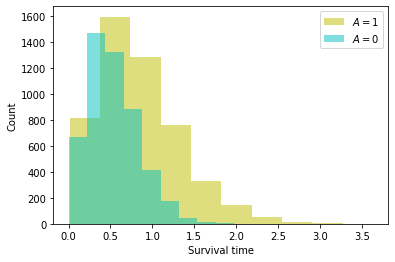

In [6]:
Y_1 = dgp.sample_outcomes("test")
Y_0 = dgp.sample_outcomes("control")
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(Y_1, label="$A = \\mathdefault{1}$", color="y", alpha=0.5);
ax.hist(Y_0, label="$A = \\mathdefault{0}$", color="c", alpha=0.5);
ax.legend();
ax.set_xlabel("Survival time");
ax.set_ylabel("Count");

For non-proportional hazards we have:

$
\alpha_{A=0} = \exp(0.7 - 1.1 X_1 + 1.2 X_2) \\
\alpha_{A=1} = \exp(0.9 - 0.3 X_1 + 0.2 X_2)
$

Check the impact your censoring rate might have!


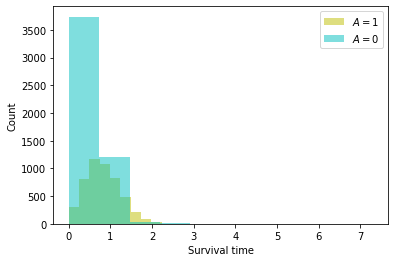

In [7]:
dgp_non_prop = DataGeneratingProcess(
                            n_samples=n_samples,
                            noise=noise,
                            random_state=random_state,
                            censoring_rate=1,
                            overlap="random",
                            proportional_hazards=False # Note that we set proportional hazards to False
                           )
Y_1 = dgp_non_prop.sample_outcomes("test")
Y_0 = dgp_non_prop.sample_outcomes("control")
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(Y_1, label="$A = \\mathdefault{1}$", color="y", alpha=0.5);
ax.hist(Y_0, label="$A = \\mathdefault{0}$", color="c", alpha=0.5);
ax.legend();
ax.set_xlabel("Survival time");
ax.set_ylabel("Count");

### Censoring times

We generate censoring times from exponential distribution with scale parametrs 1 (small proportion of censoring) and 0.3 (larger proportion of censoring).

In [11]:
for censoring_rate, prop_hazards in [(2.5, True), (2.5, False), (0.5, True), (0.5, False)]:
    illiustration_dgp = DataGeneratingProcess(
                            n_samples=n_samples,
                            noise=noise,
                            random_state=random_state,
                            censoring_rate=censoring_rate,
                            overlap="random",
                            proportional_hazards=prop_hazards
                           )
    percent = illiustration_dgp.df.delta.sum() / len(illiustration_dgp.df) * 100
    print("At censoring rate {} and proportional hazards set to {}, the proportion of censored is: {:.2f}%".format(censoring_rate,
                                                                                                             prop_hazards,
                                                                                                             percent))

At censoring rate 2.5 and proportional hazards set to True, the proportion of censored is: 23.20%
At censoring rate 2.5 and proportional hazards set to False, the proportion of censored is: 21.06%
At censoring rate 0.5 and proportional hazards set to True, the proportion of censored is: 66.02%
At censoring rate 0.5 and proportional hazards set to False, the proportion of censored is: 65.04%


then observed survival time $Y$ and censoring indiciator $\delta$ are defined as:

$
Y = \min \big( [AY_{A=1} + (1-A)Y_{A=0}], C \big) \text{,   } \delta = 1 \text{ if } Y_{A} < C, \text{ else } \delta = 0
$

dependent on the assigned treatment $A$. If suppose $A=1$ then $Y_{A=1}$ is a factual outcome, which however might be hidden behind $C$.

### Data generation process recap

To recap we have the following: 

Observed features and latent binary factor generated from make moons function,

$
X, G \sim \text{sklearn make moons}
$

Treatment assignment for random controlled trial is:

$
A \sim \text{Bernouli}(0.5)
$

and for an observation study:

$
A \sim \text{Bernoili}(\pi(x)), \text{ where } \pi(x) = \text{Pr}(A=1|X=x)
$

Given the treatment assignment we generate factual survival time $Y_A$,

$
Y_{A} = \Big[ \frac{- \log(U)}{ \lambda_{A} \exp \{m_{A}(X, G)\}} \Big]^{1/\alpha}, U \sim \text{Uniform}(0, 1), \forall A \in \{0, 1\}
$

and censoring time that is independent of everything else


$
C \sim \text{Exponential}(\gamma), \gamma \in \{2.5, 0.5 \}
$

which leads to observed time interval $Y$ and censoring indicator $\delta$

$
Y = \min \big( [AY_{A=1} + (1-A)Y_{A=0}], C \big) \text{,   } \delta = 1 \text{ if } Y_{A} < C, \text{ else } \delta = 0
$

### Causal graph

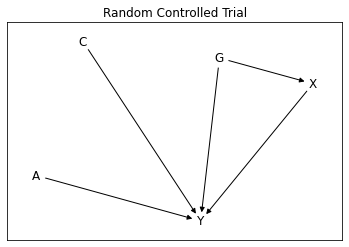

In [12]:
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('G', 'X'), ('G', 'Y'), ('C', 'Y'), ('X', 'Y'), ('A', 'Y')])
fig, ax = plt.subplots(figsize=(6,4));
nx.draw_networkx(G, arrows=True, node_color="white", ax=ax)
ax.set_title("Random Controlled Trial");

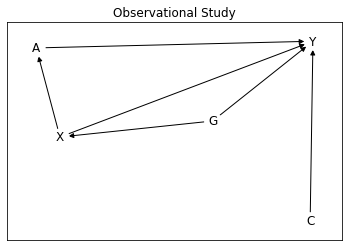

In [13]:
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('G', 'X'), ('G', 'Y'), ('C', 'Y'), ('X', 'Y'), ('A', 'Y'), ("X", "A")])
fig, ax = plt.subplots(figsize=(6,4));
nx.draw_networkx(G, arrows=True, node_color="white", ax=ax)
ax.set_title("Observational Study");

### Median survival time

As opposed to hazard ratio, several works have suggested that median survival time is of clinical relevance for causal effect estimation (practicioners might also be interested in other quantiles of the survival distribution). The population causal survival quantile effect is defined as:

$
\tau^{q} = \mathbb{E}_{X} [\mu_{A=1}^{q} - \mu_{A=0}^{q}] = \mathbb{E}_{X} \big[ \sup \{t : S_{A=1}(t) \leq q \} - \sup \{t : S_{A=0}(t) \leq q \} \big]
$ 

Median survival time is defined as the quantity satisfying $S_{A}(t) = 1/2$. If $S_{A}(.)$ is not strictly decreasing, then $t$ is the smallest value such that $S_{A}(t) \leq 1/2$. 

For our dataset where we know that potential survival times where generated from Weidbull distribution we can derive an expression for median by re-arranging $S(t) = 1/2$ in terms of $t$, which will be equivalent to our sampling function but with $1/2$ instead of $U$.

### Potential outcomes framework

The overall framework and notation we adopted above is referred to as _potential outcomes framework_ for modeling causal effects in observational and experimental studies. In our case we have a "subject" with continious features $X \in \mathcal{X}$, and unobserved categorical feature $G \in \{0, 1\}$. A subject could be a patient in the medical experiment or observational data, or an app user on facebook's platform. $A \in \{0, 1\}$ denotes a treatment variable, in this case we have only two treatment options: $A=0$ for no treatment, or control; and $A=1$ to indicate that a subject has been assigned to a treatment (e.g. new feature in an app, or hemeotherapy for a patient). The outcome variable $Y \in \mathbb{R}^{+}$, is the survival time that we have actually observed in the experiment for a particular subject. The observed outcome $Y$ takes on values of either of the two "potential outcomes" $Y_{A=1}$ or $Y_{A=0}$ which depends on the value that $A$ takes, unless cenosring time $C$ has happened earlier than the potential outcome $Y_{A}$, hence $Y = \min \big( [AY_{A=1} + (1-A)Y_{A=0}], C \big)$.

When working with observational data or data from a randomized control trials, we tipycally are given $N$ samples of the tuples $Z = (X, A, Y)$ (forgetting for a second that we may have some unobserved confounders $U$, in our case binary variable $G$). Samples $Z$ are drawn from some underlying probability distribution with paramters $\theta$

$
Z_1, ..., Z_n \sim \mathbb{P}_{\theta}
$

We may further breakdown $\theta$ into a collection a _nuissance_ paramters (paramters that are not of imediate interest but need to be accounted for):

$
\theta = \{ \mu_{A=1}, \mu_{A=0}, \pi, \eta \}
$

where $\mu_{A=1}(x) = \mathbb{E}_{\theta}[Y_{A=1}|X=x]$ and $\mu_{A=0}(x) = \mathbb{E}_{\theta}[Y_{A=0}|X=x]$ are conditional potential outcomes for a subject with features $x$. and $\pi$ is the treatment assignment mechanism,

$
\pi(x)= \mathbb{P}_\theta (A = 1 | X = x)
$

and $\eta(x) = \mathbb{P}_\theta (X=x)$. 

In the simulation above we have access to each of the steps of the data generative process, and we know that the treatment assignment is random.

Our goal is then to use causal inference techniques to infer the treatment effects function $\tau(X)$ of individual subjects based on their features using the samples $\{ Z_i \}^{N}_{i=1}$. The treatment effect function is defined as $\tau(X) = \mathbb{E}[Y_{A=1} - Y_{A=1} | X] = \mu_{A=1}(x) - \mu_{A=0}(x)$, known as Individual Treatment Effect (ITE). Our causal model $M$ maps a dataset $\{ Z_i \}^{N}_{i=1}$ to an estimate $\hat{\tau}(.)$ of ITE. The accuracy of the model is charaterised by the squarred-$L^2$ loss:

$
\epsilon_{PEHE} = || \hat{\tau}(X) - \tau(X) ||^{2}_\theta \approx \frac{1}{N} \sum^{N}_{n=1} || \hat{\tau}(X=x_n) - \tau(X=x_n) ||^{2}_\theta
$

also known as Precision of Estimating Heterogeneous Effects (PEHE), where $||f(X)||^{2}_\theta = \mathbb{E}_{\theta}[f^{2}(X)]$. 

Note that to estimate PEHE one has to have access to factual and counterfactual outcomes and their generative distribution, so that their expectations of the outcomes can be compared.

In our case we are using population treatment effect median survival time $\tau^{q} = \mathbb{E}_{X} [\mu_{A=1}^{q} - \mu_{A=0}^{q}], q=1/2 $. An ITE of that would $\tau^{q}(X) = \mathbb{E}_{X} [\mu_{A=1}^{q}(X) - \mu_{A=0}^{q}(X)], q=1/2 $, with $\mu_{A}(x) = \mathbb{E}_{\theta}[\sup \{t : S_{A}(t) \leq q \}|X=x]$

### Coming back to data

In [14]:
dgp.df.head(n=10)

,x0,x1,latent_binary_confounder,treatment_assignment,true_treatment_prob,y_test,y_control,c,mu_test,mu_control,observed,delta
0,0.175632,0.651367,0,0,0.5,2.578215,0.409099,1.041306,1.004264,0.496819,0.409099,0
1,-0.331225,-0.264673,0,0,0.5,0.914679,0.340590,0.609856,0.917159,0.707449,0.340590,0
2,0.243493,-0.167557,1,1,0.5,0.610556,0.488921,1.347929,0.606851,0.453324,0.610556,0
3,-0.038084,0.503672,0,1,0.5,1.692118,0.484350,3.477037,0.993384,0.523399,1.692118,0
4,0.139760,0.193171,0,1,0.5,1.617457,0.166320,3.676017,0.964053,0.586629,1.617457,0
5,0.442344,0.065242,0,1,0.5,1.397588,0.529820,2.649700,0.943561,0.614867,1.397588,0
6,0.064051,0.095395,1,1,0.5,0.700279,0.624796,0.659980,0.624684,0.409127,0.659980,1
7,0.244254,-0.276760,1,1,0.5,0.851444,0.846706,1.042750,0.600413,0.473042,0.851444,0
8,0.277913,0.339293,0,0,0.5,1.842669,0.332596,1.671177,0.974910,0.553546,0.332596,0
9,0.321900,0.036512,0,1,0.5,1.170386,1.417968,0.292919,0.945198,0.622868,0.292919,1


We can see our continious features $X$ as `x0` and `x1`; latent confounder $G$ as `latent_binary_confounder`; treatment assignment indicator; conditional potential outcomes $\mu_{A=1}(x)$ and $\mu_{A=0}(x)$ denoted as `mu_test` and `mu_control`; and the corresponding sampled potential outcomes `y_test` and `y_control`, censoring time `c` and the observed time `observed` and the censoring indicator `delta`.

In [15]:
print("% of treated subjects: {}".format(dgp.df.treatment_assignment.sum()/len(dgp.df)*100))
print("% of censored subjects: {:.2f}".format(dgp.df.delta.sum()/len(dgp.df)*100))

% of treated subjects: 49.46
% of censored subjects: 23.90


In [16]:
avg_rho_true = np.sum(dgp.df.mu_test - dgp.df.mu_control) / len(dgp.df)
print("Average true Treatment Effect: {:.3f}".format(avg_rho_true))

Average true Treatment Effect: 0.285


A randomized study like the one we have simulated above allows us to draw conclusions about the treatment effect. This is because randomisation (at least in sufficiently large studies) ensures that other variables predicting $Y$ have the same distribution among treated ($A=1$) and controls ($A=0$). In other words, the treatment groups are _exchangeable_.

In an observational study where treatment allocation is not under control (or non-random), as we will consider below, the situation is different and a direct comparison of the distribution of $Y$ between treated and untreated may no longer be a fair one because of the _confounding_ effect arrising possibly from different distributions of $X$ in the treatment groups.

In [11]:
from causememaybe.mlp import make_mlp
import torch
from torch import optim
from torch.autograd import Variable
X = dgp.X
y = dgp.y_test
c = dgp.c
sigma = (y < c).astype(np.int32)

In [14]:
mlp = make_mlp(2, [(2, 3), (3, 2)], include_bn=False)

In [16]:
with torch.no_grad():
    

SyntaxError: invalid syntax (<ipython-input-16-aafdb297b112>, line 1)